## Harmonic Oscillator using Physics Informed Neural Networks

This notebook was prepared for the project class of Inverse Problems. Here we reproduce the results obtained by Ben Mosely from ETH Zurih AI Center. https://github.com/benmoseley/harmonic-oscillator-pinn/tree/main

## Problem Statement

The problem to solve here is the 1D damped harmonic oscillator:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$
We will focus on solving the problem for the under-damped state, i.e. when 
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$
This has the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$

In [20]:
#Import Lubraries
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad
import torch.nn as nn
from torch.optim import Adam, LBFGS
import numpy as np
import random
from tqdm.notebook import tqdm

In [9]:
def set_device():
    device = 'cpu'
    if torch.cuda.device_count() > 0 and torch.cuda.is_available():
        print("Cuda installed! Running on GPU!")
        device = torch.device(torch.cuda.current_device())
        print(f'Device: {device} {torch.cuda.get_device_name(device)}')
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print(f'Device: {device} {(device)}')
    else:
        print("No GPU available!")
    return device

def set_seed(seed):
    """Set all random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled   = False

In [4]:
# define function to get the analitycal solution
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

#### Generate trainig data

For this problem, we use $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $x\in [0,1]$.

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


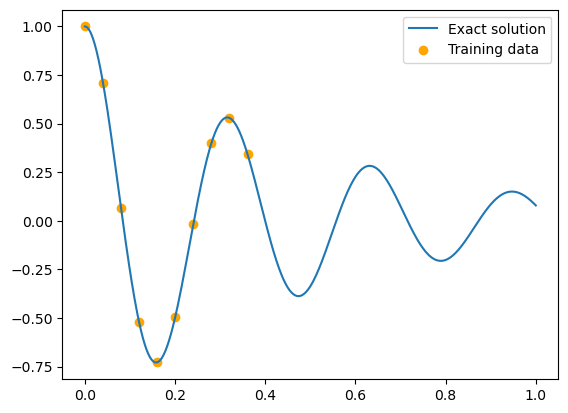

In [3]:
d, w0 = 2, 20

# get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="orange", label="Training data")
plt.legend()
plt.show()

#### Multi Layer Perceptron

In [21]:
# instantiate the model --> MLP
set_seed(123)
model = FCN(N_INPUT = 1, N_OUTPUT = 1, N_HIDDEN = 32, N_LAYERS = 3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

num_epochs = 1000
loss_history = []
for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())


  0%|          | 0/1000 [00:00<?, ?it/s]

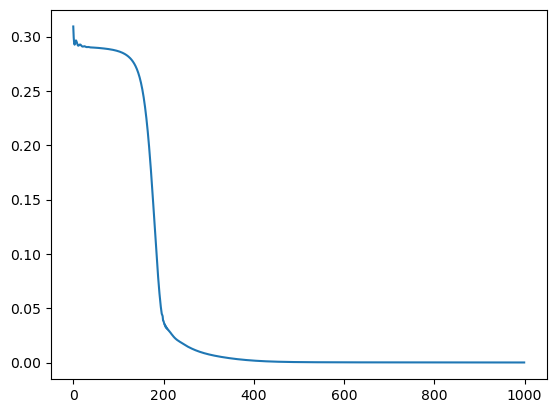

In [16]:
plt.plot(loss_history)

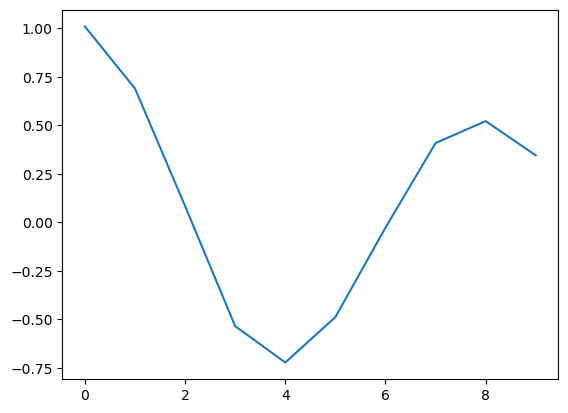

In [24]:
plt.plot(yh.detach())